# Multi-Agent Financial System with LangGraph 1.0

This notebook demonstrates a **multi-agent system** using LangGraph 1.0. The system consists of six specialized agents:
- Finance Q&A Agent
- Portfolio Analysis Agent
- Market Analysis Agent
- Goal Planning Agent
- News Synthesizer Agent
- Tax Education Agent

A **Workflow Router** inspects user queries and routes them to the appropriate agent(s).

I want to use caching, validation, evaluation, and other supporting components as a toggle that can be turned on or off


✅ Need to do the following -
✅ Per‑agent memory  
✅ Caching toggles  
✅ Evaluation nodes  
✅ Validation nodes  
✅ A “meta‑agent” that supervises the others  
✅ A fallback agent for ambiguous queries


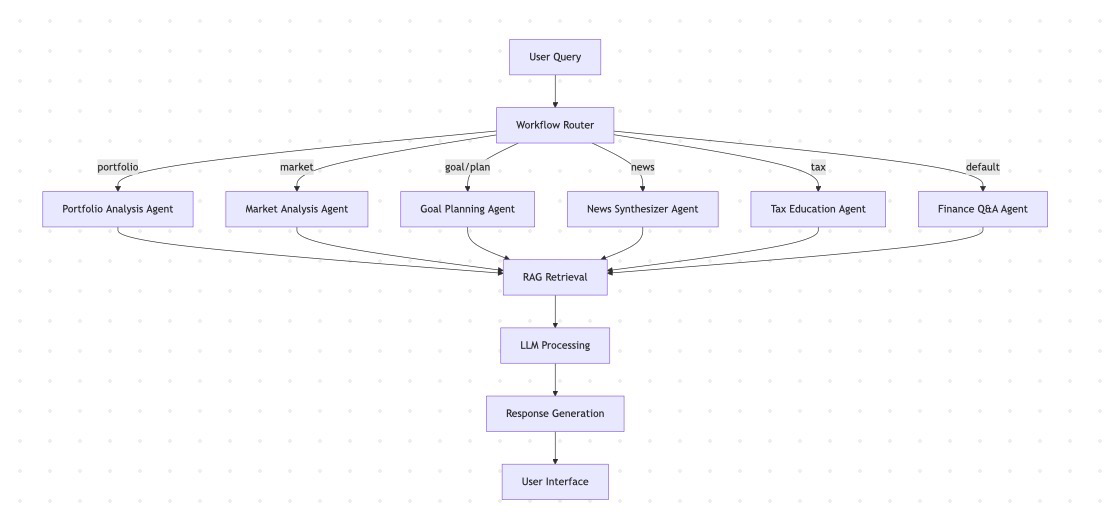

In [ ]:
# Initialize LLM
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.7,
)

# Define chatbot node
def chatbot(state: MessagesState):
    """Process messages and generate response"""
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

In [9]:
from langgraph.graph import StateGraph, END
from langgraph.graph.message import MessagesState
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import HumanMessage, AIMessage

# --- Agent Nodes ---
def finance_agent(state: MessagesState):
    return {"messages": state["messages"] + ["Finance Q&A Agent response"]}

def portfolio_agent(state: MessagesState):
    return {"messages": state["messages"] + ["Portfolio Analysis Agent response"]}

def market_agent(state: MessagesState):
    return {"messages": state["messages"] + ["Market Analysis Agent response"]}

def goal_agent(state: MessagesState):
    return {"messages": state["messages"] + ["Goal Planning Agent response"]}

def news_agent(state: MessagesState):
    return {"messages": state["messages"] + ["News Synthesizer Agent response"]}

def tax_agent(state: MessagesState):
    return {"messages": state["messages"] + ["Tax Education Agent response"]}



In [10]:
# --- User Query Node ---
def user_query_node(state: MessagesState):
    # This node represents the entry point where the user submits a query
    return {**state, "messages": state["messages"]}

Note - * * state - The unpacking operator (**) takes all key-value pairs from the state dictionary and spreads them into the new dictionary

"route": dest - Adds a new key called "route" with the value stored in dest (like "portfolio", "market", etc.)

Why do this? In LangGraph, nodes typically return an updated state. This pattern preserves all existing state data while adding new information (the routing decision). The graph can then use this "route" value in conditional edges to determine which node to execute next.

Important: If state already had a "route" key, this would overwrite it since the explicit "route": dest comes after the unpacking.

In [22]:
# --- Router Node ---
def workflow_router(state: MessagesState):
    last_msg = state["messages"][-1]
    query = last_msg.content.lower()

    if "portfolio" in query:
        dest = "portfolio"
    elif "market" in query:
        dest = "market"
    elif "goal" in query or "plan" in query:
        dest = "goal"
    elif "news" in query:
        dest = "news"
    elif "tax" in query:
        dest = "tax"
    else:
        dest = "finance"   # default fallback

    return {**state, "route": dest}

In [13]:
# 1. Define your state
class State(dict):
    pass

In [14]:
# 2. Build the graph
graph = StateGraph(State)

In [15]:
# --- Build Graph ---
graph = StateGraph(MessagesState)

graph.add_node("user_query", user_query_node)
graph.add_node("finance", finance_agent)
graph.add_node("portfolio", portfolio_agent)
graph.add_node("market", market_agent)
graph.add_node("goal", goal_agent)
graph.add_node("news", news_agent)
graph.add_node("tax", tax_agent)
graph.add_node("router", workflow_router)



In [16]:
# End edges
graph.add_edge("finance", END)
graph.add_edge("portfolio", END)
graph.add_edge("market", END)
graph.add_edge("goal", END)
graph.add_edge("news", END)
graph.add_edge("tax", END)



In [17]:
# Connect user query to router
graph.add_edge("user_query", "router")

In [18]:


# Conditional routing from router
graph.add_conditional_edges(
    "router",
    lambda state: state["route"],  # look at the "route" key
    {
        "finance": "finance",
        "portfolio": "portfolio",
        "market": "market",
        "goal": "goal",
        "news": "news",
        "tax": "tax",
    },
)

In [19]:
# Set entry point as user_query
graph.set_entry_point("user_query")

# Compile with memory (SQLite checkpointer)
#checkpointer = SqliteSaver.from_conn_string("memory.db")
#graph = builder.compile(checkpointer=checkpointer)

#app = graph.compile(checkpointer=checkpointer)

checkpointer = SqliteSaver.from_conn_string("memory.db")
app = graph.compile(checkpointer=checkpointer)

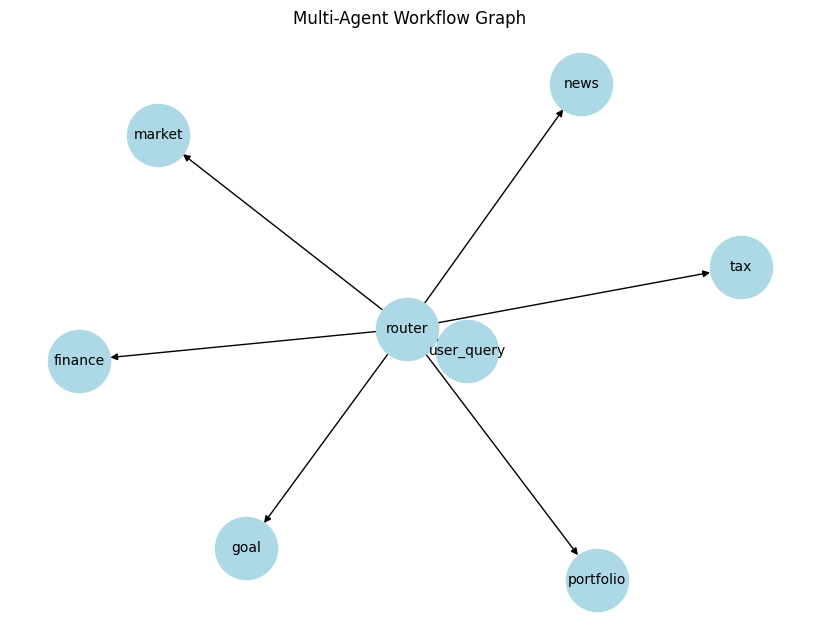

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

# Define nodes and edges manually based on your LangGraph setup
nodes = ["user_query", "router", "finance", "portfolio", "market", "goal", "news", "tax"]
edges = [
    ("user_query", "router"),
    ("router", "finance"),
    ("router", "portfolio"),
    ("router", "market"),
    ("router", "goal"),
    ("router", "news"),
    ("router", "tax"),
]

# Create a NetworkX graph
nx_graph = nx.DiGraph()
nx_graph.add_nodes_from(nodes)
nx_graph.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(8,6))
nx.draw(nx_graph, with_labels=True, node_color="lightblue", node_size=2000, font_size=10, arrows=True)
plt.title("Multi-Agent Workflow Graph")
plt.show()

In [ ]:


# --- Test run ---
result = app.invoke({"messages": [HumanMessage(content="Can you analyze my portfolio?")]})
print(result["messages"][-1].content)

## Data Flow Diagram

```
User Query
    ↓
Workflow Router
    ├── "portfolio" → Portfolio Analysis Agent
    ├── "market"   → Market Analysis Agent
    ├── "goal"     → Goal Planning Agent
    ├── "news"     → News Synthesizer Agent
    ├── "tax"      → Tax Education Agent
    └── else       → Finance Q&A Agent
```